<a href="https://colab.research.google.com/github/DeependraChaddha/Kaggle_Competitions/blob/main/Forecasting_Sticker_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following code is for getting submission for Kaggle competition Forecasting Sticker Sales(link: https://www.kaggle.com/competitions/playground-series-s5e1/overview)

#Make imports

In [ ]:
!pip install autogluon holidays

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import autogluon
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import holidays as hd

#Device Information

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Visualziing data

##Printing all datsets

In [ ]:
original_train_data = pd.read_csv('train.csv')
print(f"The training data has {original_train_data.shape[0]} rows")
original_train_data.head(10)

The training data has 230130 rows


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
6,6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0
7,7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0
8,8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0
9,9,2010-01-01,Canada,Stickers for Less,Kerneler Dark Mode,940.0


In [ ]:
test_data = pd.read_csv('test.csv')
print(f"The testing data has {test_data.shape[0]} rows")
print(test_data.head())
print(test_data.tail())

The testing data has 98550 rows
       id        date country              store             product
0  230130  2017-01-01  Canada  Discount Stickers   Holographic Goose
1  230131  2017-01-01  Canada  Discount Stickers              Kaggle
2  230132  2017-01-01  Canada  Discount Stickers        Kaggle Tiers
3  230133  2017-01-01  Canada  Discount Stickers            Kerneler
4  230134  2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode
           id        date    country                 store             product
98545  328675  2019-12-31  Singapore  Premium Sticker Mart   Holographic Goose
98546  328676  2019-12-31  Singapore  Premium Sticker Mart              Kaggle
98547  328677  2019-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers
98548  328678  2019-12-31  Singapore  Premium Sticker Mart            Kerneler
98549  328679  2019-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode


In [ ]:
submission_format = pd.read_csv('sample_submission.csv')
print(submission_format.shape)
print(submission_format.head())
print(submission_format.tail())

(98550, 2)
       id  num_sold
0  230130       100
1  230131       100
2  230132       100
3  230133       100
4  230134       100
           id  num_sold
98545  328675       100
98546  328676       100
98547  328677       100
98548  328678       100
98549  328679       100


##Checking for NaN values

In [ ]:
def check_nan(df:pd.DataFrame):
  # Check for NaN values
  has_nan = df.isnull().any().any()
  return has_nan

In [ ]:
print(f"The training data has NaN values: {check_nan(original_train_data)}")
print(f"The testing data has NaN values: {check_nan(test_data)}")

The training data has NaN values: True
The testing data has NaN values: False


In [ ]:
original_train_data.isnull().any()

,0
id,False
date,False
country,False
store,False
product,False
num_sold,True


some num_sold values missing in training data, but cannot remove them will need to fill in values later

In [ ]:
# Remove rows where 'num_sold' column has NaN values
#train_data = original_train_data.dropna(subset=['num_sold']).copy()
#print(f"The training data has {train_data.shape[0]} rows")
#train_data.head(10)
#REMOVED ABOVE CODE AS IT LED TO INCOMPLETE DATA
train_data=original_train_data.copy()

##Checking datatypes in the dataframe

In [ ]:
#checking datatypes of each column
train_data.dtypes

,0
id,int64
date,object
country,object
store,object
product,object
num_sold,float64


In [ ]:
# Convert date column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date']=pd.to_datetime(test_data['date'])

In [ ]:
train_data.describe(include='all')

,id,date,country,store,product,num_sold
count,230130.000000,230130,230130,230130,230130,221259.000000
unique,NaN,NaN,6,3,5,NaN
top,NaN,NaN,Canada,Discount Stickers,Holographic Goose,NaN
freq,NaN,NaN,38355,76710,46026,NaN
mean,115064.500000,2013-07-02 00:00:00,NaN,NaN,NaN,752.527382
min,0.000000,2010-01-01 00:00:00,NaN,NaN,NaN,5.000000
25%,57532.250000,2011-10-02 00:00:00,NaN,NaN,NaN,219.000000
50%,115064.500000,2013-07-02 00:00:00,NaN,NaN,NaN,605.000000
75%,172596.750000,2015-04-02 00:00:00,NaN,NaN,NaN,1114.000000
max,230129.000000,2016-12-31 00:00:00,NaN,NaN,NaN,5939.000000


##Including new variable to get more information

Adding information about a given data in training data is a holiday or not


In [ ]:
#make a function to check if a date is a holiday in a specific country or not
def is_holiday(row):
  #get list of holidays in specific country
  country_holidays=hd.country_holidays(row['country'])

  #Return True if date belongs in that list
  return row['date'] in country_holidays

In [ ]:
#apply is_holiday on training and testing datasets
train_data['holiday']=train_data.apply(is_holiday, axis=1)
test_data['holiday']=test_data.apply(is_holiday, axis=1)

Add info about following:
1. Weekend or weekday
2. Season
3. Fiscal Quarter
4. Currency Exchange Rate
5. COVID if applicable
6. War if applicable
7. End of Year effect (more spending near new years generally)
8. Start of month effect

In [ ]:
#make new column in training data containing day of week
train_data['day_of_week']=train_data['date'].dt.day_name()
test_data['day_of_week']=test_data['date'].dt.day_name()

In [ ]:
#getting season on the date
def get_season(date):
  month=date.month
  season='spring' if 3<=month<=5 else 'summer' if 6<=month<=8 else 'autumn' if 9<=month<=11 else 'winter'
  return season

#applying above function on training and testing data
train_data['season']=train_data['date'].apply(get_season)
test_data['season']=test_data['date'].apply(get_season)
train_data['season']

,season
0,winter
1,winter
2,winter
3,winter
4,winter
...,...
230125,winter
230126,winter
230127,winter
230128,winter


In [ ]:
#Make fiscal Quarter Column with 1 from April to June, 2 from July to September, 3 from October to December, 4 January to March
def get_fiscal_quarter(date):
  month = date.month
  quarter= 1 if month in [4,5,6] else 2 if month in [7,8,9] else 3 if month in [10,11,12] else 4 if month in [1,2,3] else 0
  return quarter


#apply above function to training and testing dataset
train_data['fiscal_quarter']=train_data['date'].apply(get_fiscal_quarter)
test_data['fiscal_quarter']=test_data['date'].apply(get_fiscal_quarter)

In [ ]:
#Make column to check if date is near new years or not(Between 15 December to 15 January)
def near_new_year(date):
  month=date.month
  day=date.day
  return True if (15<=day<=31 and month==12) or (1<=day<=15 and month==1) else False

#Apply function to both the datasets
train_data['near_new_year']=train_data['date'].apply(near_new_year)
test_data['near_new_year']=test_data['date'].apply(near_new_year)

In [ ]:
#Check if date is near start of the month (up till 5th of the month)
def near_start_of_month(date):
  day=date.day
  return True if day<=5 else False

#Apply to both datasets
train_data['near_start_of_month']=train_data['date'].apply(near_start_of_month)
test_data['near_start_of_month']=test_data['date'].apply(near_start_of_month)

##Checking if data is significantly assymetrically distributed around categorical variables or not

In [ ]:
# Count the number of rows for each country
country_counts = train_data['country'].value_counts()

# Display the result
print(country_counts)

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64


In [ ]:
# Count the number of rows for each country
product_counts = train_data['product'].value_counts()

# Display the result
print(product_counts)

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64


In [ ]:
# Count the number of rows for each country
store_counts = train_data['store'].value_counts()

# Display the result
print(store_counts)

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64


In [ ]:
print(f'countries in training dataset:{train_data["country"].unique()}')
print(f'countries in testing dataset:{test_data["country"].unique()}')

countries in training dataset:['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
countries in testing dataset:['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']


In [ ]:
print(f'stores in training dataset:{train_data["store"].unique()}')
print(f'stores in testing dataset:{test_data["store"].unique()}')

stores in training dataset:['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
stores in testing dataset:['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']


In [ ]:
print(f'products in training dataset:{train_data["product"].unique()}')
print(f'products in testing dataset:{test_data["product"].unique()}')

products in training dataset:['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']
products in testing dataset:['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


In [ ]:
print(f' Number of Unique values of all categorical variables:Day of Week:{train_data["day_of_week"].nunique()}, Quarter: {train_data["fiscal_quarter"].nunique()}, Holiday: {train_data["holiday"].nunique()}, New Year: {train_data["near_new_year"].nunique()}, Start of Month: {train_data["near_start_of_month"].nunique()}, Season: {train_data["season"].nunique()}')

 Number of Unique values of all categorical variables:Day of Week:7, Quarter: 4, Holiday: 2, New Year: 2, Start of Month: 2, Season: 4


It seems above that number of data points are not very different in training and testing data

##Attempting more visualization

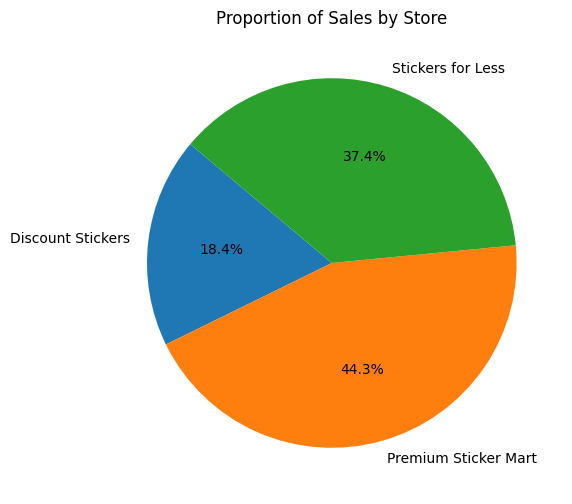

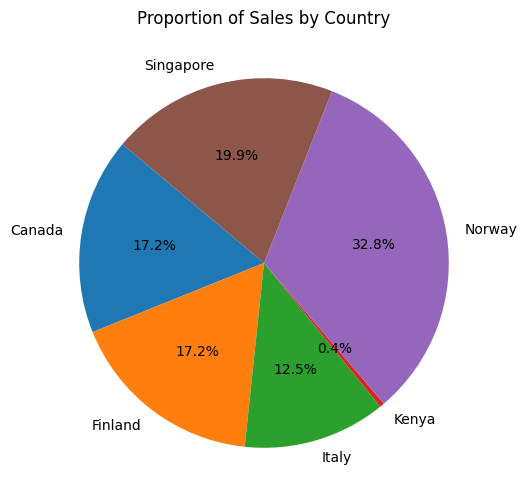

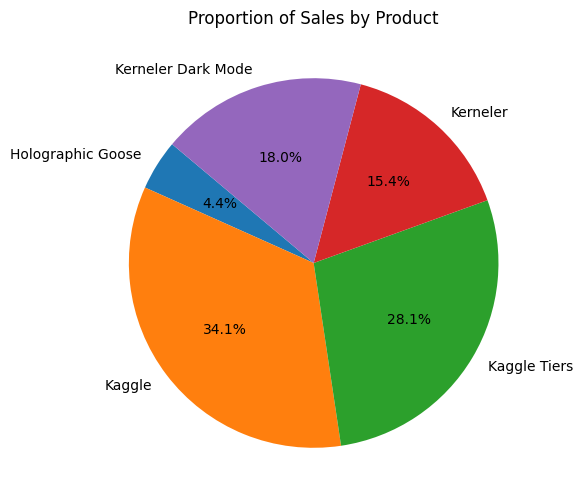

In [ ]:
# 1. Pie Chart for `num_sold` against `store`, `country`, and `product`
categories = ['store', 'country', 'product']
for category in categories:
    aggregated = train_data.groupby(category)['num_sold'].sum()
    plt.figure(figsize=(8, 6))
    plt.pie(aggregated, labels=aggregated.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of Sales by {category.capitalize()}')
    plt.show()


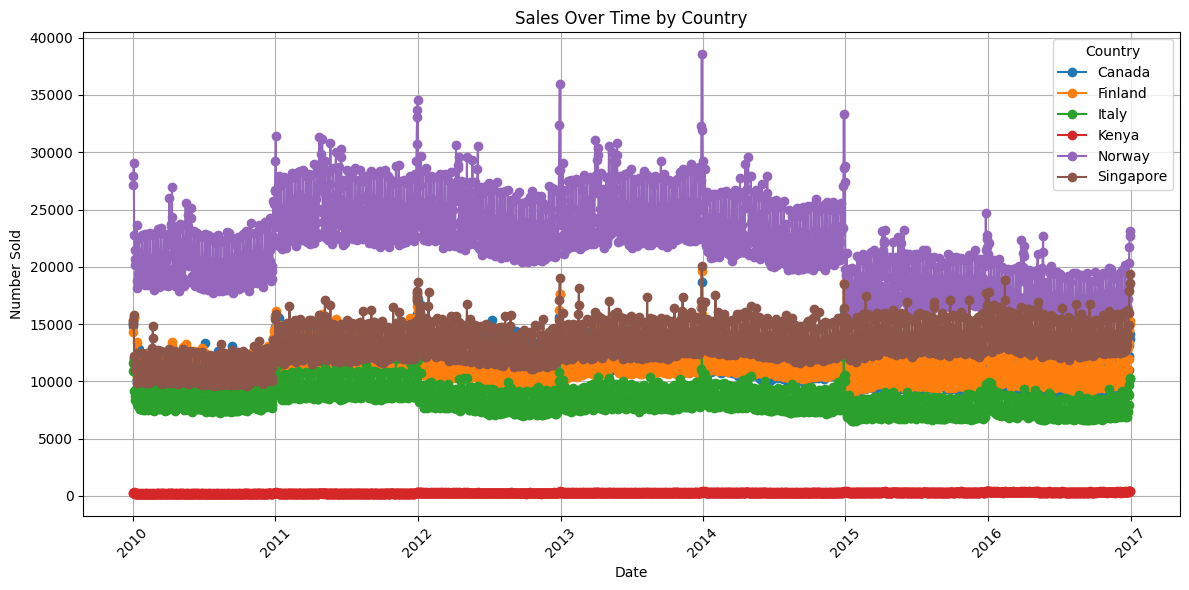

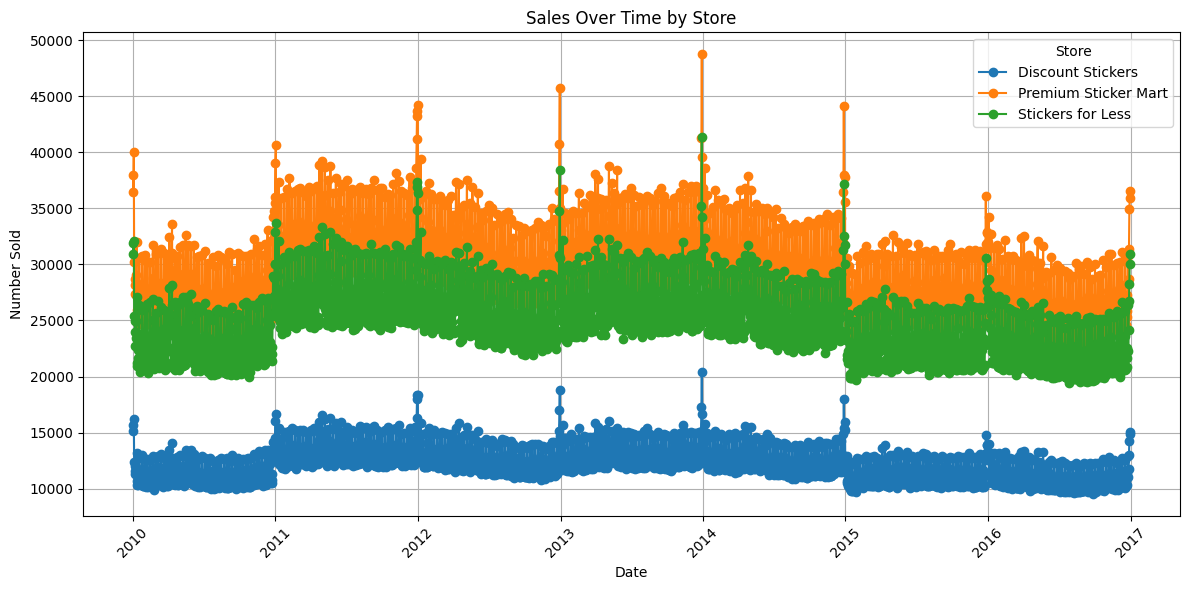

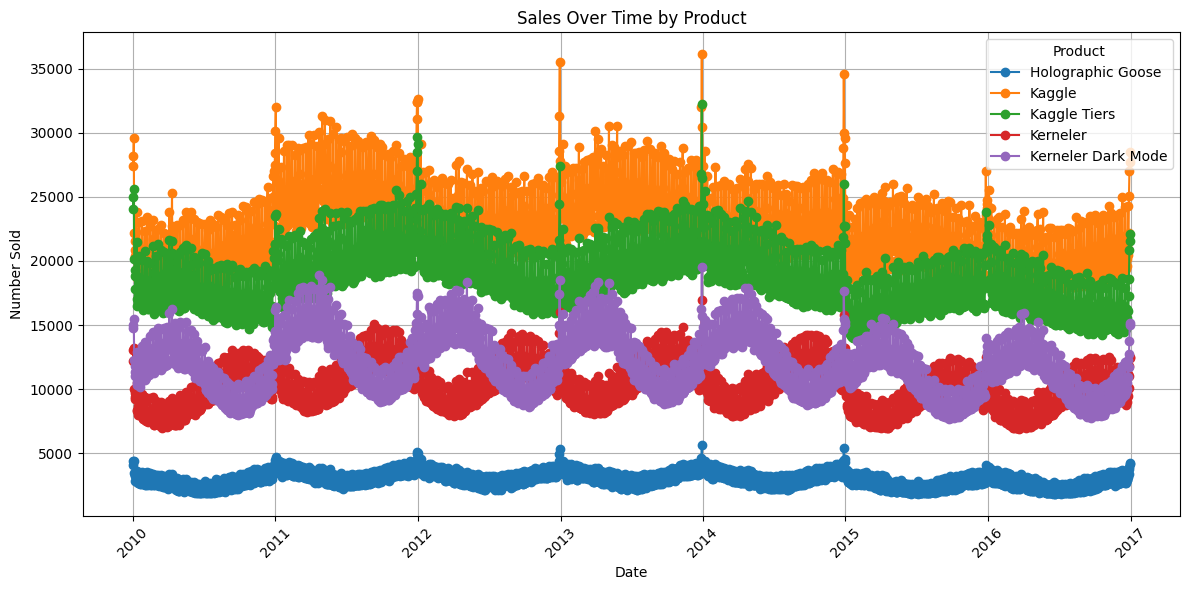

In [ ]:
# Function to plot grouped data
def plot_grouped_data(df, group_column, title):
    grouped = df.groupby([group_column, 'date'])['num_sold'].sum().reset_index()
    unique_groups = grouped[group_column].unique()

    plt.figure(figsize=(12, 6))
    for group in unique_groups:
        group_data = grouped[grouped[group_column] == group]
        plt.plot(group_data['date'], group_data['num_sold'], marker='o', label=f"{group}")

    plt.xlabel('Date')
    plt.ylabel('Number Sold')
    plt.title(title)
    plt.legend(title=group_column.capitalize())
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for each category
plot_grouped_data(train_data, 'country', 'Sales Over Time by Country')
plot_grouped_data(train_data, 'store', 'Sales Over Time by Store')
plot_grouped_data(train_data, 'product', 'Sales Over Time by Product')

##Checking skewness of target variable

In [ ]:
import numpy as np
print(train_data['num_sold'].skew())  # A skewness > 1 suggests log transformation might help


1.415373452498392


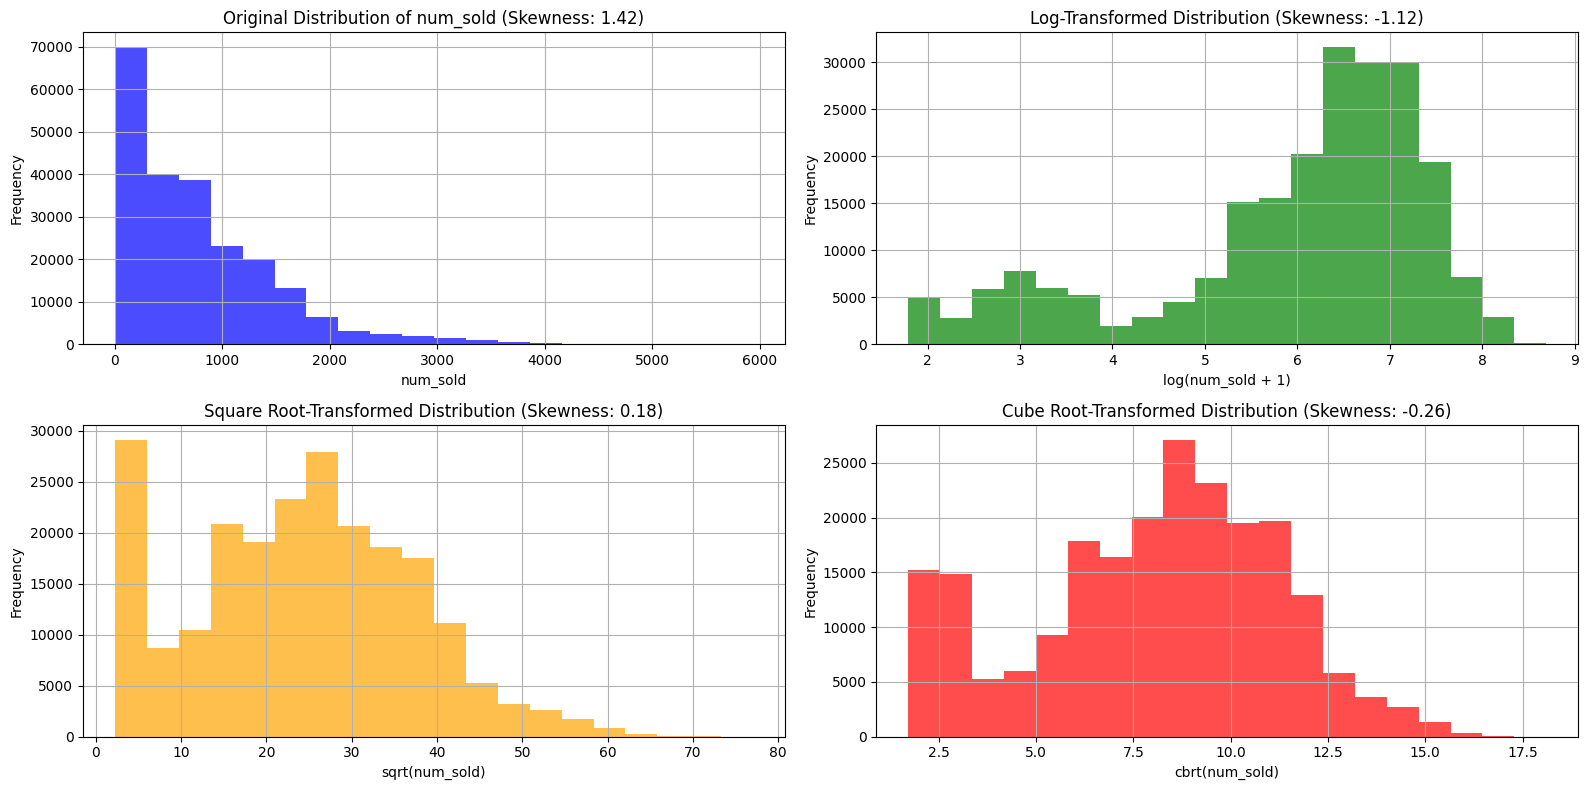

In [ ]:
# Create transformed versions of num_sold
train_data['log_num_sold'] = np.log(train_data['num_sold'] + 1)  # Add 1 to avoid issues with zeros
train_data['sqrt_num_sold'] = np.sqrt(train_data['num_sold'])
train_data['cbrt_num_sold'] = np.cbrt(train_data['num_sold'])

# Calculate skewness for each column
skewness_original = train_data['num_sold'].skew()
skewness_log = train_data['log_num_sold'].skew()
skewness_sqrt = train_data['sqrt_num_sold'].skew()
skewness_cbrt = train_data['cbrt_num_sold'].skew()

# Plot distributions with skewness in titles
plt.figure(figsize=(16, 8))

# Original data
plt.subplot(2, 2, 1)
train_data['num_sold'].hist(bins=20, color='blue', alpha=0.7)
plt.title(f'Original Distribution of num_sold (Skewness: {skewness_original:.2f})')
plt.xlabel('num_sold')
plt.ylabel('Frequency')

# Log-transformed data
plt.subplot(2, 2, 2)
train_data['log_num_sold'].hist(bins=20, color='green', alpha=0.7)
plt.title(f'Log-Transformed Distribution (Skewness: {skewness_log:.2f})')
plt.xlabel('log(num_sold + 1)')
plt.ylabel('Frequency')

# Square root-transformed data
plt.subplot(2, 2, 3)
train_data['sqrt_num_sold'].hist(bins=20, color='orange', alpha=0.7)
plt.title(f'Square Root-Transformed Distribution (Skewness: {skewness_sqrt:.2f})')
plt.xlabel('sqrt(num_sold)')
plt.ylabel('Frequency')

# Cube root-transformed data
plt.subplot(2, 2, 4)
train_data['cbrt_num_sold'].hist(bins=20, color='red', alpha=0.7)
plt.title(f'Cube Root-Transformed Distribution (Skewness: {skewness_cbrt:.2f})')
plt.xlabel('cbrt(num_sold)')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
train_data.head()

,id,date,country,store,product,num_sold,holiday,day_of_week,season,fiscal_quarter,near_new_year,near_start_of_month,log_num_sold,sqrt_num_sold,cbrt_num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,True,Friday,winter,4,True,True,NaN,NaN,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,True,Friday,winter,4,True,True,6.881411,31.192948,9.909178
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,True,Friday,winter,4,True,True,6.810142,30.099834,9.676302
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,True,Friday,winter,4,True,True,6.049733,20.566964,7.506661
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,True,Friday,winter,4,True,True,6.198479,22.158520,7.889095


#Training

##Preparing dataframe for training

In [ ]:
# Ensure 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

In [ ]:
train_data.dtypes

,0
id,int64
date,datetime64[ns]
country,object
store,object
product,object
num_sold,float64
holiday,bool
day_of_week,object
season,object
fiscal_quarter,int64


In [ ]:
# Rename 'date' column to 'timestamp' to match AutoGluon's expected format
train_data.rename(columns={'date': 'timestamp'}, inplace=True)


In [ ]:
# Create the 'item_id' column that combines 'country', 'store', and 'product' to uniquely identify time series, since this will be used, the 3 columns are not required to be input in model separately
train_data['item_id'] = train_data['country'] + '_' + train_data['store'] + '_' + train_data['product']


In [ ]:
train_data['item_id'].nunique()

90

##Training

In [ ]:
# Step 1: Prepare data for TimeSeriesDataFrame
# Assuming train_data already has columns: 'timestamp', 'item_id', 'holiday', and 'sqrt_num_sold'
train_data_ts = TimeSeriesDataFrame(train_data[['timestamp', 'item_id', 'holiday', 'day_of_week','season', 'fiscal_quarter', 'near_new_year', 'near_start_of_month', 'sqrt_num_sold']])

# Step 2: Handle missing values in TimeSeriesDataFrame
# This uses forward fill followed by backward fill by default
train_data_ts = train_data_ts.fill_missing_values()

# Step 3: Adjust frequency (e.g., 'D' for daily)
train_data_ts.convert_frequency(freq='D')

# Step 4: Initialize the TimeSeriesPredictor
predictor = TimeSeriesPredictor(
    target='sqrt_num_sold',
    prediction_length=test_data['date'].nunique(),  # Predicting for number of unique dates in test_data
    freq='D',
    eval_metric='MAPE'  # Set MAPE as the evaluation metric
)

# Step 5: Specify GPU usage for deep learning models
hyperparameters = {
    "DeepAR": {"use_gpu": True},  # Enable GPU for DeepAR
    "TemporalFusionTransformer": {"use_gpu": True},  # Enable GPU for TFT
    "PatchTST": {"use_gpu": True},  # Enable GPU for PatchTST
    "TiDE": {"use_gpu": True}  # Enable GPU for TiDE
}

# Step 6: Fit the model with the data
predictor.fit(train_data_ts, presets='best_quality', hyperparameters=hyperparameters)

# Step 7: Retrieve model performance and sort by MAPE
performance = predictor.leaderboard(train_data_ts, silent=True)
performance_sorted = performance[['model', 'score_val']].sort_values(by='score_val', ascending=True)

# Step 8: Print MAPE of models in increasing order
print("MAPE of models in increasing order:")
print(performance_sorted)

Trying to fill missing values in an unsorted dataframe. It is highly recommended to call `ts_df.sort_index()` before calling `ts_df.fill_missing_values()`
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250122_165912'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.11 GB / 12.67 GB (87.7%)
Disk Space Avail:   75.61 GB / 107.72 GB (70.2%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': {'DeepAR': {'use_gpu': True},
                     'PatchTST': {'use_gpu': True},
                     'TemporalFusionTransformer': {'use_gpu': True},
                     'TiDE': {'use_gpu': True}},
 'known_covariates_names': 

#Forecast

##Making same transformations to test_data

In [ ]:
test_data.dtypes

,0
id,int64
date,object
country,object
store,object
product,object
holiday,bool


In [ ]:
#convert date to detetime
test_data['date'] = pd.to_datetime(test_data['date'])

In [ ]:
# Rename 'date' column to 'timestamp' to match AutoGluon's expected format
test_data.rename(columns={'date': 'timestamp'}, inplace=True)
print(test_data['timestamp'].dtype)

datetime64[ns]


In [ ]:
# Create 'item_id' for future data
test_data['item_id'] = test_data['country'] + '_' + test_data['store'] + '_' + test_data['product']

In [ ]:
test_data['item_id'] = test_data['item_id'].astype(str)

In [ ]:
test_data.columns

Index(['id', 'timestamp', 'country', 'store', 'product', 'holiday', 'item_id'], dtype='object')

In [ ]:
# Prepare future data as TimeSeriesDataFrame
test_data_filtered = test_data[['timestamp', 'item_id', 'holiday']]
test_data_filtered = test_data_filtered.set_index(['item_id', 'timestamp'])
test_data_ts = TimeSeriesDataFrame(test_data_filtered)#filtering out required columns for prediction


In [ ]:
print(test_data_ts.index.names)
print(test_data_ts.columns)
print(test_data.head())

['item_id', 'timestamp']
Index(['holiday'], dtype='object')
       id  timestamp country              store             product  holiday  \
0  230130 2017-01-01  Canada  Discount Stickers   Holographic Goose     True   
1  230131 2017-01-01  Canada  Discount Stickers              Kaggle     True   
2  230132 2017-01-01  Canada  Discount Stickers        Kaggle Tiers     True   
3  230133 2017-01-01  Canada  Discount Stickers            Kerneler     True   
4  230134 2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode     True   

                                       item_id  
0   Canada_Discount Stickers_Holographic Goose  
1              Canada_Discount Stickers_Kaggle  
2        Canada_Discount Stickers_Kaggle Tiers  
3            Canada_Discount Stickers_Kerneler  
4  Canada_Discount Stickers_Kerneler Dark Mode  


##Forecasting

In [ ]:
# Make predictions for sqrt_num_sold
future_forecast = predictor.predict(data=train_data_ts)
future_forecast


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean  \
item_id                                           timestamp               
Canada_Discount Stickers_Holographic Goose        2017-01-01   1.828386   
                                                  2017-01-02   1.530369   
                                                  2017-01-03   1.694148   
                                                  2017-01-04   1.685733   
                                                  2017-01-05   1.676713   
...                                                                 ...   
Singapore_Premium Sticker Mart_Kerneler Dark Mode 2019-12-27  30.694326   
                                                  2019-12-28  31.719497   
                                                  2019-12-29  32.830855   
                                                  2019-12-30  29.183521   
                                                  2019-12-31  28.997989   

                                                                    0.1  \
item_id                                           timestamp               
Canada_Discount Stickers_Holographic Goose        2017-01-01  -0.228932   
                                                  2017-01-02  -0.186991   
                                                  2017-01-03  -0.492751   
                                                  2017-01-04  -0.660720   
                                                  2017-01-05  -0.688972   
...                                                                 ...   
Singapore_Premium Sticker Mart_Kerneler Dark Mode 2019-12-27  27.644016   
                                                  2019-12-28  28.567728   
                                                  2019-12-29  29.405500   
                                                  2019-12-30  27.080511   
                                                  2019-12-31  26.713958   

                                                                    0.2  \
item_id                                           timestamp               
Canada_Discount Stickers_Holographic Goose        2017-01-01   0.513026   
                                                  2017-01-02   0.591466   
                                                  2017-01-03   0.236948   
                                                  2017-01-04   0.165607   
                                                  2017-01-05   0.155990   
...                                                                 ...   
Singapore_Premium Sticker Mart_Kerneler Dark Mode 2019-12-27  28.861758   
                                                  2019-12-28  29.859481   
                                                  2019-12-29  30.703795   
                                                  2019-12-30  27.933491   
                                                  2019-12-31  27.600915   

                                                                    0.3  \
item_id                                           timestamp               
Canada_Discount Stickers_Holographic Goose        2017-01-01   1.093993   
                                                  2017-01-02   0.934397   
                                                  2017-01-03   0.756870   
                                                  2017-01-04   0.853610   
                                                  2017-01-05   0.775495   
...                                                                 ...   
Singapore_Premium Sticker Mart_Kerneler Dark Mode 2019-12-27  29.397238   
                                                  2019-12-28  30.332404   
                                                  2019-12-29  31.315041   
                                                  2019-12-30  28.269788   
                                                  2019-12-31  28.077007   

                                                                    0.4  \
item_id                                           timestamp               
Canada_Discou

In [ ]:
future_forecast.columns

Index(['mean', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'], dtype='object')

In [ ]:
# Convert sqrt_num_sold predictions back to num_sold
future_forecast['num_sold'] = future_forecast['mean']**2

##Doing a Left Join Operation to get correct num_sold for each id

In [ ]:
#left join future forecast to test_data to get correct ids with the num_sold forecast
final_forecast = future_forecast.merge(test_data[['id', 'item_id', 'timestamp']],
                                       on=['item_id', 'timestamp'],
                                       how='left')
# Display the predictions
print("Future predictions for num_sold:")
print(final_forecast[['id', 'num_sold']])

Future predictions for num_sold:
           id     num_sold
0      230130     3.342996
1      230220     2.342030
2      230310     2.870137
3      230400     2.841697
4      230490     2.811367
...       ...          ...
98545  328319   942.141632
98546  328409  1006.126497
98547  328499  1077.865033
98548  328589   851.677919
98549  328679   840.883365

[98550 rows x 2 columns]


In [ ]:
final_forecast.columns

Index(['item_id', 'timestamp', 'mean', '0.1', '0.2', '0.3', '0.4', '0.5',
       '0.6', '0.7', '0.8', '0.9', 'num_sold', 'id'],
      dtype='object')

##Checking if any value is NaN or missing

In [ ]:
#Check for NaN values in all columns
future_forecast.isnull().any()

,0
mean,False
0.1,False
0.2,False
0.3,False
0.4,False
0.5,False
0.6,False
0.7,False
0.8,False
0.9,False


In [ ]:
# Convert both columns to lists
final_forecast_ids = final_forecast['id'].tolist()
submission_format_ids = submission_format['id'].tolist()

difference = list(set(submission_format_ids)-set(final_forecast_ids))
difference #empty list implies no difference so our output matches expected submission format

[]

#Saving required dataframe

In [ ]:
#save final_forecast['id', 'num_sold']
final_forecast[['id', 'num_sold']].to_csv('submission.csv', index=False)

#Plotting forecast

#Saving model

Got Temporal Fusion Transformer as best model

In [ ]:
# Get the name of the best model
best_model = predictor.model_best

# Extract the best model's object
best_model_obj = predictor._trainer.load_model(best_model)

# Save the best model separately
import pickle
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model_obj, f)

print(f"Best model '{best_model}' saved as 'best_model.pkl'")

Best model 'TemporalFusionTransformer' saved as 'best_model.pkl'


In [ ]:
from google.colab import files

# Download the saved best model file
files.download("best_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>